<a href="https://colab.research.google.com/github/jespimentel/perfil_procuradoria_mpsp/blob/master/perfil_procuradoria_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install camelot-py --q

In [ ]:
import pandas as pd
import camelot
from datetime import datetime

df = pd.DataFrame()

tabelas = camelot.read_pdf('/content/drive/MyDrive/Datasets/listas_de_antiguidade/0810 Lista de Antiguidade I - Procurador.pdf', pages='all')

for tabela in tabelas:
  df = pd.concat([df, tabela.df[1:]], ignore_index=True)

df = df.drop(df.columns[6], axis=1) # A coluna 6 não possui informações
display(df.head(5))

,0,1,2,3,4,5,7,8,9,10,11,12,13,14
0,1,618461,Pedro Franco de Campos,22/12/2005,1º Procurador de Justiça da Procuradoria de Ju...,Procurador\n28/12/1985,Procurador,28/12/1985,14.614,13/09/1977,17.642,17/05/1980,2.051,06/05/1954
1,2,480141,José Correia de Arruda Neto,22/12/2005,14º Procurador de Justiça da Procuradoria de J...,Procurador\n29/06/1988,Procurador,29/06/1988,13.700,13/01/1976,18.251,22/03/1979,3.387,29/07/1952
2,3,152307,Carlos Augusto Salles Sgarbi,22/12/2005,5º Procurador de Justiça da Procuradoria de Ju...,Procurador\n29/09/1988,Procurador,29/09/1988,13.608,01/12/1978,17.198,04/02/1981,2.794,28/01/1952
3,4,973510,Sergio Neves Coelho,22/12/2005,4º Procurador de Justiça da Procuradoria de Ju...,Procurador\n11/01/1992,Procurador,11/01/1992,12.409,10/10/1979,16.885,04/05/1983,3.174,07/09/1955
4,5,578347,Walter Paulo Sabella,22/12/2005,35º Procurador de Justiça da Procuradoria de J...,Procurador\n11/01/1992,Procurador,11/01/1992,12.409,10/10/1979,16.885,09/08/1983,3.077,17/07/1951


In [ ]:
df.columns = ['Classif.', 'Matr.', 'Nome', 'Data inclusão', 'Cargo', 'Sit. 2005', 'Entr. atual', 'Data entr. atual', 'Dias', 'Inic. carreira', 'Dias', 'Data entr. anterior', 'Dias', 'Nascimento']

col_datas = ['Data inclusão', 'Data entr. atual', 'Data entr. anterior', 'Inic. carreira', 'Nascimento']
for col in col_datas:
  df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

In [ ]:
from datetime import datetime
ano_hoje = datetime.now().year
df['Idade'] = (ano_hoje - df['Nascimento'].dt.year)
df['Idade na promoção'] = df['Data entr. atual'].dt.year - df['Nascimento'].dt.year
df['Ano da promoção'] = df['Data entr. atual'].dt.year
df['Tempo de carreira na promoção'] = (df['Data entr. atual'].dt.year - df['Inc. carreira'].dt.year)
df['Tempo de procuradoria'] = (ano_hoje - df['Data entr. atual'].dt.year)
df

# Enriquecimento dos dados com LLM

In [ ]:
!pip install litellm --q

In [ ]:
from litellm import completion
from google.colab import userdata

In [ ]:
modelo = 'gpt-4o-mini'
api_key = userdata.get('OPENAI_API_KEY')

prompt = f"""
- Você analisará um nome. Sua única tarefa é dizer se o nome é **masculino** ou **feminino**.
- Se tiver dúvida, responda com masculino ou feminino, o que for mais provável.
- Nenhuma outra resposta é válida.
<exemplos>
<exemplo 1>
**Nome fornecido:** José da Silva Júnior
**Saída:** masculino
</exemplo 1>
<exemplo 2>
**Nome fornecido:** Maria das Graças
**Gênero:** feminino
</exemplo 2>
</exemplos>
---
**Nome fornecido:**
"""

def analisar_conteudo (texto, prompt, modelo, api_key):
  try:
    resultado = completion(
    model=modelo,
    messages=[
        {"role": "system", "content": "Você é um linguista."},
        {"role": "user", "content": f"**Instruções:**\n {prompt}"},
        {"role": "user", "content": f"{texto}"},
       ],
        api_key=api_key,
        temperature=0,
        #max_tokens=64000,
    )
    return resultado.get('choices', [{}])[0].get('message', {}).get('content', 'Sem resposta.')
  except Exception as e:
    print(f"Erro: {e}")
    return None


In [ ]:
df['gênero'] = df['Nome'].apply(lambda x: analisar_conteudo(x, prompt, modelo, api_key))
df

In [ ]:
# Criação do arquivo Excel para conferência
df.to_excel('/content/drive/MyDrive/Datasets/listas_de_antiguidade/procuradores.xlsx', index=False)

# Análises
## (após conferência manual)

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Datasets/listas_de_antiguidade/procuradores.xlsx')
display(df.head(3))

In [86]:
df[['Idade', 'Tempo de procuradoria', 'Idade na promoção', 'Tempo de carreira na promoção']].describe()

,Idade,Tempo de procuradoria,Idade na promoção,Tempo de carreira na promoção
count,319.000000,319.000000,319.000000,319.000000
mean,63.448276,11.943574,51.504702,25.115987
std,4.684008,9.096441,6.704861,6.227528
min,55.000000,0.000000,31.000000,8.000000
25%,60.000000,5.000000,47.000000,21.000000
50%,63.000000,11.000000,52.000000,25.000000
75%,67.000000,16.000000,57.000000,31.000000
max,74.000000,40.000000,67.000000,40.000000


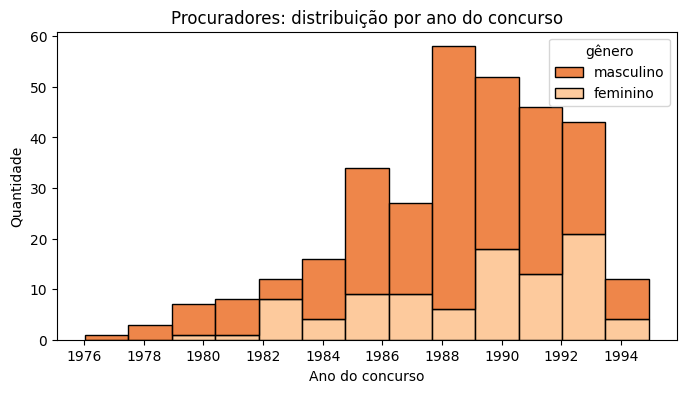

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(
    data=df,
    x='Inc. carreira',
    hue='gênero',
    multiple='stack',
    palette='Oranges_r',
    ax=ax
    )
plt.title('Procuradores: distribuição por ano do concurso')
plt.xlabel('Ano do concurso')
plt.ylabel('Quantidade')
plt.show()

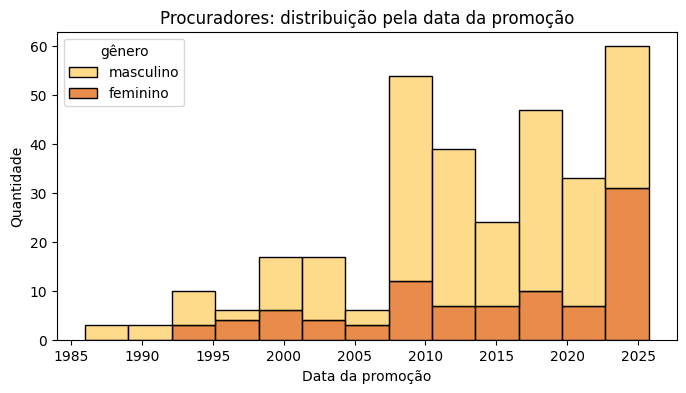

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(
    data=df,
    x='Data entr. atual',
    hue='gênero',
    multiple='stack',
    ax=ax,
    palette='YlOrBr'
    )
plt.title('Procuradores: distribuição pela data da promoção')
plt.xlabel('Data da promoção')
plt.ylabel('Quantidade')
plt.show()

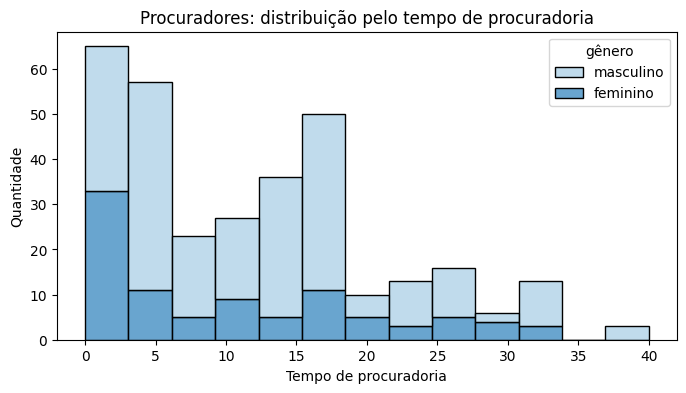

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(
    data=df,
    x='Tempo de procuradoria',
    hue='gênero',
    multiple='stack',
    ax=ax,
    palette='Blues'
    )
plt.title('Procuradores: distribuição pelo tempo de procuradoria')
plt.xlabel('Tempo de procuradoria')
plt.ylabel('Quantidade')
plt.show()

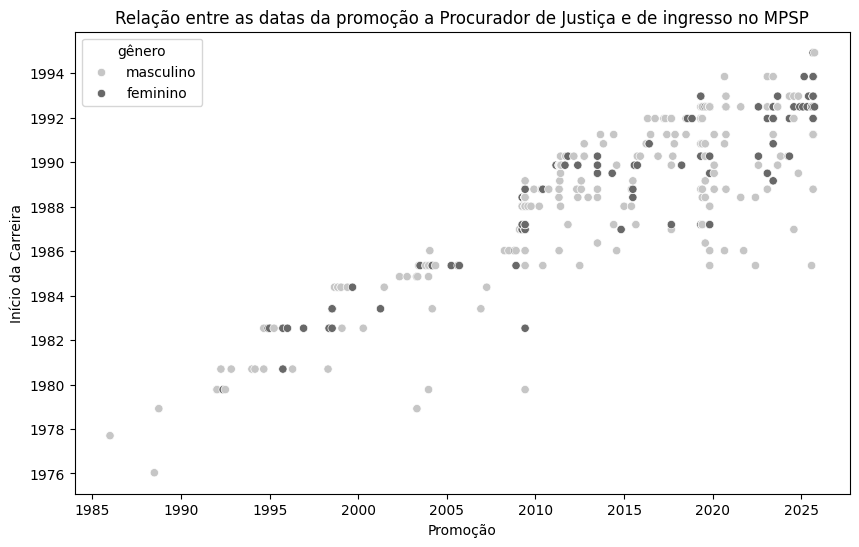

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Data entr. atual',
    y='Inc. carreira',
    hue='gênero',
    palette='Grays',
    ax=ax
)
plt.title('Relação entre as datas da promoção a Procurador de Justiça e de ingresso no MPSP')
plt.xlabel('Promoção')
plt.ylabel('Início da Carreira')
plt.savefig('/content/drive/MyDrive/Datasets/listas_de_antiguidade/scatterplot.png')
plt.show()

In [91]:
df_grouped = df.groupby(['Ano da promoção', 'gênero'])['Idade na promoção'].mean()
df_grouped = df_grouped.reset_index()
df_grouped

,Ano da promoção,gênero,Idade na promoção
0,1985,masculino,31.000000
1,1988,masculino,36.000000
2,1992,feminino,38.000000
3,1992,masculino,38.000000
4,1993,masculino,36.000000
...,...,...,...
56,2023,masculino,57.900000
57,2024,feminino,59.500000
58,2024,masculino,60.142857
59,2025,feminino,58.250000


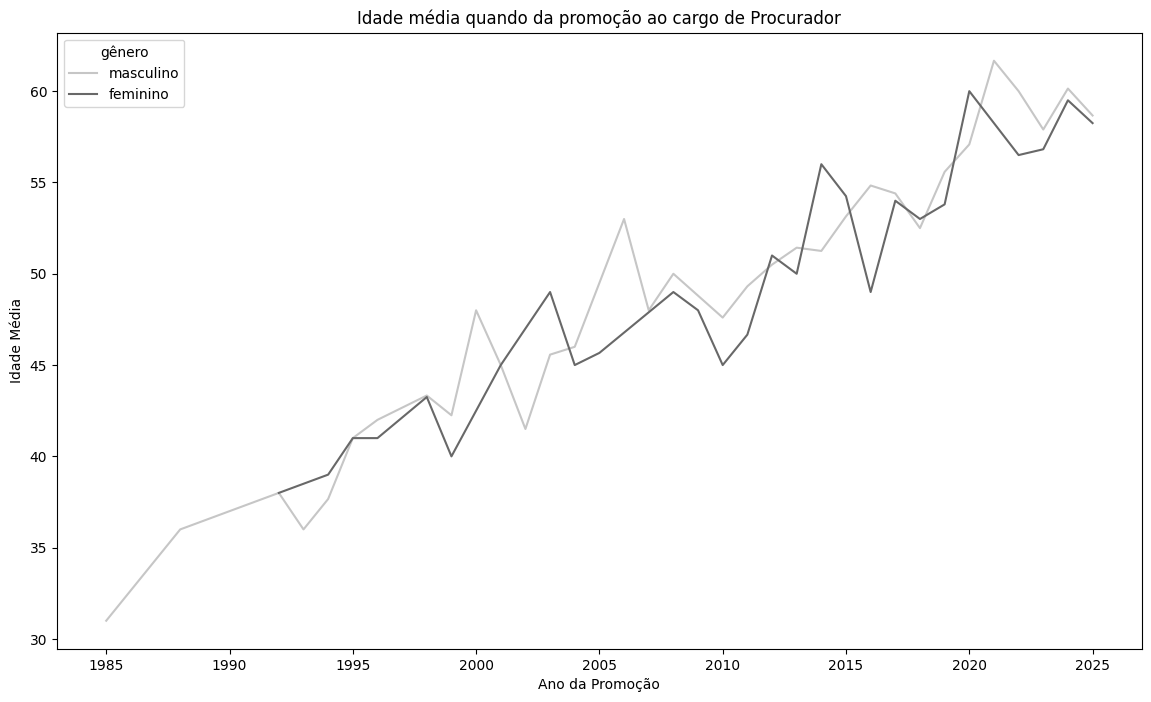

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
sns.lineplot(
    data=df_grouped,
    x='Ano da promoção',
    y='Idade na promoção',
    hue='gênero',
    palette='Grays',
    ax=ax
)
plt.title('Idade média quando da promoção ao cargo de Procurador')
plt.xlabel('Ano da Promoção')
plt.ylabel('Idade Média')
plt.savefig('/content/drive/MyDrive/Datasets/listas_de_antiguidade/lineplot_idade.png')
plt.show()

In [93]:
df_grouped_1 = df.groupby(['Ano da promoção', 'gênero'])['Tempo de carreira na promoção'].mean()
df_grouped_1 = df_grouped_1.reset_index()
df_grouped_1

,Ano da promoção,gênero,Tempo de carreira na promoção
0,1985,masculino,8.000000
1,1988,masculino,11.000000
2,1992,feminino,13.000000
3,1992,masculino,12.666667
4,1993,masculino,13.000000
...,...,...,...
56,2023,masculino,32.100000
57,2024,feminino,32.750000
58,2024,masculino,33.714286
59,2025,feminino,32.812500


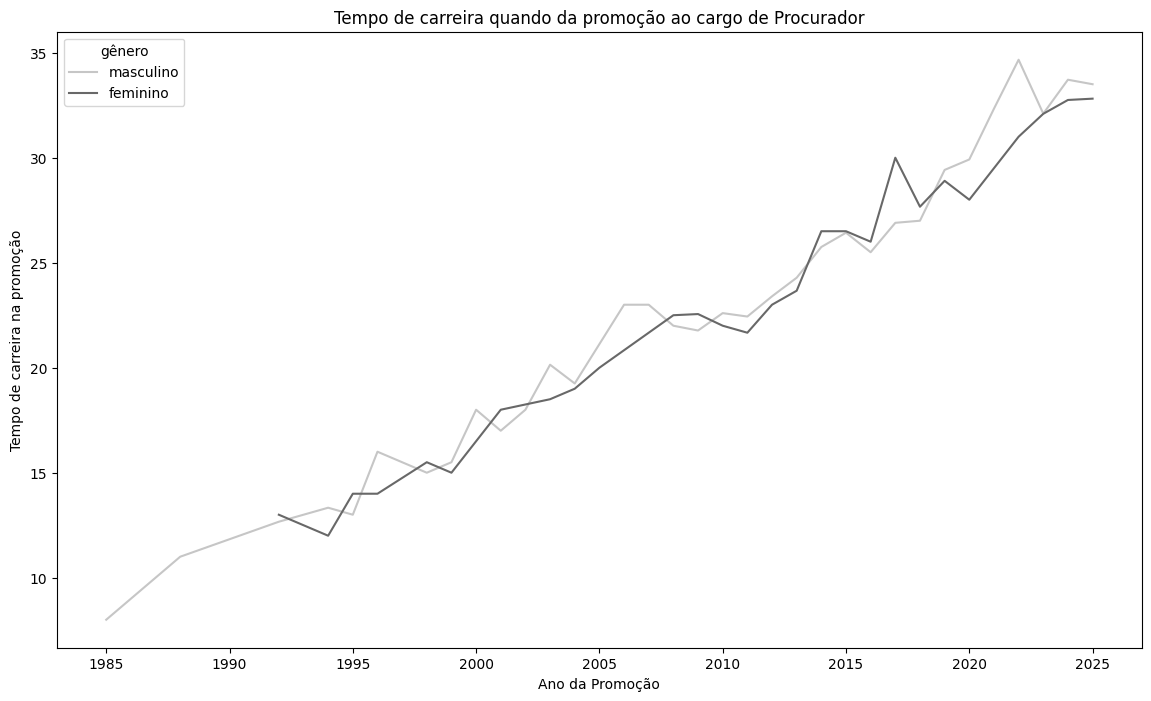

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
sns.lineplot(
    data=df_grouped_1,
    x='Ano da promoção',
    y='Tempo de carreira na promoção',
    hue='gênero',
    palette='Grays',
    ax=ax
)
plt.title('Tempo de carreira quando da promoção ao cargo de Procurador')
plt.xlabel('Ano da Promoção')
plt.ylabel('Tempo de carreira na promoção')
plt.savefig('/content/drive/MyDrive/Datasets/listas_de_antiguidade/lineplot_tempo_carreira.png')
plt.show()